In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import torch
import optuna
import pyreadr

from glob import glob

from utils.analysis import xval_station_metrics
from models.temporal_nets import LSTM
import yaml

/home/kraftb/.conda/envs/engression/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_rds(path: str | os.PathLike) -> pd.DataFrame:
    return pyreadr.read_r(path)[None]

In [3]:
study_dict = {}

for path in glob('/net/argon/landclim/kraftb/machflow_engression/runs_timesplit/*/xval/optuna.db'):
    study = optuna.load_study(
        study_name='LSTM',
        storage=f'sqlite:///{path}')
    study_dict[path] = study.best_trial.values[0]

In [4]:
best_idx = np.argmin(list(study_dict.values()))
best_path = list(study_dict.keys())[best_idx]
best_checkpoint_path = best_path.replace('optuna.db', 'fold_000/checkpoints/best.ckpt')

In [5]:
lstm = LSTM.load_from_checkpoint(best_checkpoint_path, map_location='cpu')

In [6]:
with open('/net/argon/landclim/kraftb/machflow/runs/staticall_allbasins_sqrttrans/LSTM/xval/fold_000/config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
ds = xr.open_zarr('/net/argon/landclim/kraftb/machflow/data/harmonized_basins.zarr')
df = read_rds('/net/argon/landclim/kraftb/machflow_engression/drought_operational/20240429/forecast/forecast_extract.rds')
df.date = pd.to_datetime(df.date)
df['Q'] = np.nan

In [7]:
from lightning import LightningModule

In [36]:
class ProductionWrapper(LightningModule):
    def __init__(self, model: LightningModule, config: dict, ds: xr.Dataset):
        super().__init__()
        self.model = model

    def forward(self, x, s):

        return self.model(x, s, tau=None)

def save_model(dir: str, config: dict, ds: xr.Dataset, model: LightningModule):

    model_path = os.path.join(dir, 'model.onnx')
    data_path = os.path.join(dir, 'data.nc')
    config_path = os.path.join(dir, 'config.yaml')

    with open(config_path, 'w') as f:
        yaml.dump(config, f)

    static_features = config['data']['init_args']['stat_features']
    dynamic_features = config['data']['init_args']['features']
    ds_stat = ds[static_features]
    if os.path.exists(data_path):
        os.remove(data_path)
    ds_stat.to_netcdf(data_path, 'w')

    wrapper = ProductionWrapper(model, config, ds)
    wrapper.eval()

    input_sample = {
        'x': torch.randn((87, len(dynamic_features), 46)),
        's': torch.randn((87, len(static_features))),
    }
    wrapper.to_onnx(model_path, input_sample, export_params=True)

import onnxruntime

def run_model(dir: str, meteo_path: str, n_samples: int = 50):
    model_path = os.path.join(dir, 'model.onnx')
    data_path = os.path.join(dir, 'data.nc')
    config_path = os.path.join(dir, 'config.yaml')

    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    static_features = config['data']['init_args']['stat_features']
    dynamic_features = config['data']['init_args']['features']

    df = read_rds(meteo_path)
    df.date = pd.to_datetime(df.date)
    df['Q'] = np.nan

    ids = df.mach_ID.unique()

    ds = xr.open_dataset(data_path)

    s = ds.sel(station=ids)[static_features].to_array('variable').transpose('station', ...).values.astype('float32')

    ort_session = onnxruntime.InferenceSession(model_path)

    for member in  df.member.unique():
        df_member = df[df.member == member]

        x_df = df_member.groupby('mach_ID')[dynamic_features].apply(lambda x: x.to_numpy().astype('float32'))[ids]

        x = np.stack(
                x_df, axis=0
            ).transpose((0, 2, 1))

        onnxruntime_input = {
            input_arg.name: input_value for input_arg, input_value in zip(ort_session.get_inputs(), [x, s])
        }

        ort_outs = ort_session.run(None, onnxruntime_input)[0]

        preds = []
        for _ in range(n_samples):
            pred = ort_session.run(None, onnxruntime_input)[0][:, 0, :]
            preds.append(pred)
        preds = np.quantile(np.stack(preds, 0), 0.5, axis=0)

        df.loc[df.member == member, 'Q'] = preds.flatten()

    return df

In [33]:
with open('/net/argon/landclim/kraftb/machflow/runs/staticall_allbasins_sqrttrans/LSTM/xval/fold_000/config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
ds = xr.open_zarr('/net/argon/landclim/kraftb/machflow/data/harmonized_basins.zarr')

In [34]:
save_model('./lstm_dir/', config=config, ds=ds, model=lstm)

/home/kraftb/.conda/envs/engression/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:4661: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [37]:
df = run_model(
    './lstm_dir/',
    '/net/argon/landclim/kraftb/machflow_engression/drought_operational/20240429/forecast/forecast_extract.rds')

Text(0.5, 1.0, 'CHFO-0251')

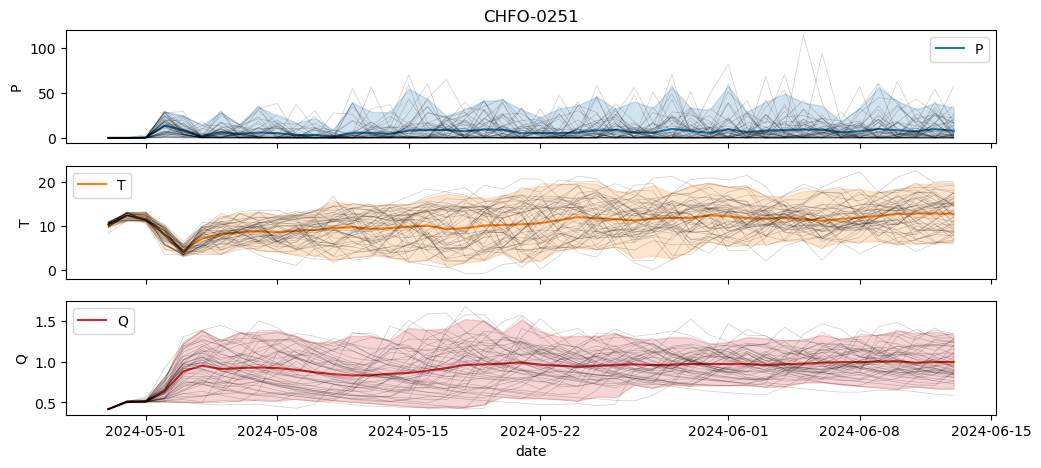

In [38]:
fig, ax = plt.subplots(3, 1, figsize=(12, 5), sharex=True)
s = 'CHFO-0251'
palette = sns.color_palette(['0.'], len(df['member'].unique()))

sns.lineplot(df.loc[df.mach_ID == s], x='date', y='P', color='tab:blue', errorbar='pi', label='P', ax=ax[0])
sns.lineplot(df.loc[df.mach_ID == s], x='date', y='P', hue='member', errorbar='pi', legend=False, palette=palette, lw=0.5, alpha=0.2, ax=ax[0])
sns.lineplot(df.loc[df.mach_ID == s], x='date', y='T', color='tab:orange', errorbar='pi', label='T', ax=ax[1])
sns.lineplot(df.loc[df.mach_ID == s], x='date', y='T', hue='member', errorbar='pi', legend=False, palette=palette, lw=0.5, alpha=0.2, ax=ax[1])
sns.lineplot(df.loc[df.mach_ID == s], x='date', y='Q', color='tab:red', errorbar='pi', label='Q', ax=ax[2])
sns.lineplot(df.loc[df.mach_ID == s], x='date', y='Q', hue='member', errorbar='pi', legend=False, palette=palette, lw=0.5, alpha=0.2, ax=ax[2])

ax[0].set_title(s)

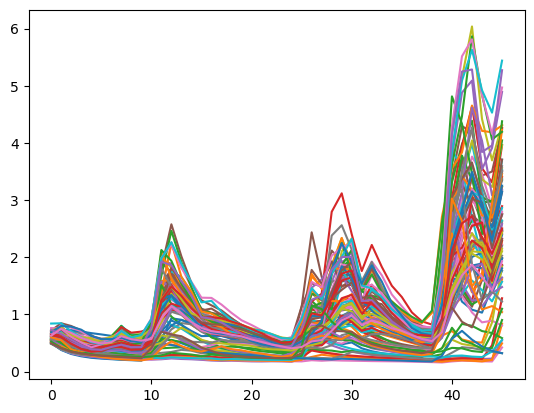

In [105]:
plt.plot(lstm(x.transpose(1, 2), s, 0.5).squeeze().detach().T);